In [1]:
# import basic libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits
from unicodedata import normalize
from io import StringIO
from scipy.stats import mode
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib
import json
import pickle
matplotlib.rcParams["figure.figsize"] = (20,10)
%matplotlib inline
#display maximum columns
pd.set_option('display.max_columns', None)
#remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f'% x)

In [2]:
# reading in data, and specifying the types
missing_values = ["n/a", "na", "<na>", "--"]
muta = pd.read_csv('valeursfoncieres-20201.csv', sep='|', parse_dates=['Date mutation'],  na_values = missing_values, decimal="."
                    ,dtype={'Code service CH':'object', 'Reference document':'object', '1 Articles CGI':'object', '2 Articles CGI':'object',
                        '3 Articles CGI':'object', '4 Articles CGI':'object', '5 Articles CGI':'object', 'No disposition':'object',
                         'Nature mutation':'object', 'No voie':'object', 'B/T/Q':'object', 'Type de voie':'object', 'Code voie':'object',   
                        'Voie':'object', 'Code commune':'object', 'Prefixe de section':'object','Code postal':'object', 
                        'No plan':'object', '4eme lot':'object', '5eme lot':'object', 'Code type local':'object', 'Identifiant local':'object', 
                        'Nombre pieces principales':'object'})
muta["Valeur fonciere"] = [float(str(i).replace(",", ".")) for i in muta["Valeur fonciere"]]
muta.columns = [c.replace(' ', '_') for c in muta.columns]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (18,23,24,26,28,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#we noticed that we have missing values and also noticed that it is impossible to have surface reele bati and surface terrain for a maison and appartment and industrial sectors
#to be zero. We applied this intuiton below, thus dropping some lines
muta.describe()

Valeur_fonciere  Nombre_de_lots  Surface_reelle_bati  Surface_terrain
count      2427808.000     2459560.000          1314270.000      1691885.000
mean        751173.518           0.391               88.635         2862.449
std        7687440.578           0.772              750.398        16094.815
min              0.150           0.000                0.000            0.000
25%          65000.000           0.000               18.000          226.000
50%         155000.000           0.000               63.000          593.000
75%         275706.340           1.000               96.000         1710.000
max      490000000.000         150.000           218290.000     10723091.000

In [4]:
#from the above information, we noticed some strange values like 0 for number piece principal for appartment and masion and idustirel
muta[(muta["Nombre_pieces_principales"]=='0')].shape

(385324, 43)

In [5]:
#view of lines where NPP is 0 without type local dependence
muta[(muta['Nombre_pieces_principales'] == '0') & (muta['Type_local'] !='Dépendance')].shape

(86963, 43)

In [6]:
#We dropped the rows with NPP for maison and appartment and industrial sector equals zero =0 since it makes no sense
muta1=muta[(muta['Nombre_pieces_principales'] == '0') & (muta['Type_local'] !='Dépendance')].index
muta.drop(muta1, inplace = True)# we dropped 86963 lines because it has 0 NPP for maison and appartment. Not true. We are left with 2457988 observations

In [7]:
#surface reele bati must not be less than 9 to be considered any type local. Those that are below 9m2 are 304086 lines
muta[(muta["Surface_reelle_bati"] < 9)].shape

(299041, 43)

In [8]:
#We dropped the rows with NPP for maison and appartment =0 since it makes no sense
muta2=muta[(muta['Surface_reelle_bati'] < 9) & (muta['Type_local'] !='Dépendance')].index
muta.drop(muta2, inplace = True)# we drop 680 lines because it has 0 NPP for maison and appartment. Not true. We are left with 2457988 observations

In total we have 2371917 observations

In [9]:
muta.to_csv('mt.csv', index=False)#export our data

cleaning

In [10]:
#cleaning commence
#missing. a larger proportion of the data are missing
missing5 = muta.isnull().sum().sort_values(ascending=False)
p1 = muta.isnull().sum()/muta.isnull().count()*100
p2 = (round(p1, 1)).sort_values(ascending=False)
missing_d3 = pd.concat([missing5, p2], axis=1, keys=['Total', '%'])
missing_d3

Total       %
Code_service_CH             2371917 100.000
4_Articles_CGI              2371917 100.000
Reference_document          2371917 100.000
5_Articles_CGI              2371917 100.000
Identifiant_local           2371917 100.000
3_Articles_CGI              2371917 100.000
2_Articles_CGI              2371917 100.000
1_Articles_CGI              2371917 100.000
Surface_Carrez_du_5eme_lot  2371596 100.000
Surface_Carrez_du_4eme_lot  2371070 100.000
5eme_lot                    2369380  99.900
Surface_Carrez_du_3eme_lot  2367853  99.800
4eme_lot                    2365542  99.700
No_Volume                   2365151  99.700
3eme_lot                    2350901  99.100
Surface_Carrez_du_2eme_lot  2323340  98.000
B/T/Q                       2271868  95.800
Prefixe_de_section          2266238  95.500
Nature_culture_speciale     2265519  95.500
2eme_lot                    2226018  93.800
Surface_Carrez_du_1er_lot   2175946  91.700
1er_lot                     1650816  69.600
Surface_reelle_bati         1145290  48.300
Nombre_pieces_principales   1145290  48.300
Type_local                  1143726  48.200
Code_type_local             1143726  48.200
Type_de_voie                1008435  42.500
No_voie                      988876  41.700
Nature_culture               731321  30.800
Surface_terrain              731321  30.800
Voie                          31121   1.300
Code_postal                   30990   1.300
Code_voie                     30948   1.300
Valeur_fonciere               30499   1.300
Section                          85   0.000
No_plan                           0   0.000
Code_commune                      0   0.000
Code_departement                  0   0.000
Commune                           0   0.000
Nombre_de_lots                    0   0.000
Nature_mutation                   0   0.000
Date_mutation                     0   0.000
No_disposition                    0   0.000

In [11]:
#drop columns based on threshold limit
#remaining 22 columns
threshold_limit = len(muta) * 0.50
muta_thresh = muta.dropna(axis=1, thresh=threshold_limit)
muta_thresh.shape

(2371917, 21)

In [12]:
# we can drop this as we find them not to be expedient
to_drop =['No_voie', 'Type_de_voie', 'Code_voie', 'Voie']
muta_thresh = muta_thresh.drop(to_drop, axis=1)

In [13]:
muta_thresh.describe()

Valeur_fonciere  Nombre_de_lots  Surface_reelle_bati  Surface_terrain
count      2341418.000     2371917.000          1226627.000      1640596.000
mean        667825.743           0.380               63.440         2820.641
std        6865137.939           0.665               54.699        15391.056
min              0.150           0.000                0.000            0.000
25%          65000.000           0.000               16.000          225.000
50%         153000.000           0.000               62.000          590.000
75%         270000.000           1.000               94.000         1690.000
max      490000000.000          46.000             2426.000     10723091.000

IMPUTATION COMMENCE BASED ON LOCATION SINCE IT IS ONE OF THE VITAL DETERMINANTS OF LAND VALUES AND ALSO THE ONLY MEANS TO AN END FOR THIS DATA. GROUPBY BY LOCATION IMPUTATION

In [14]:
#we created a grouped ID based on specific characterics of a location
muta_thresh['idx_client'] = muta_thresh.groupby(['Commune', 'Code_commune', 'Code_departement']).ngroup()

In [15]:
#The standard mode imputation approach not working. 
# Reason: because some groups/locations 
# have all missing values.Hence have no a mode. we created a rapid mode function for imputation
def rapid_mode(df, key_cols, value_col):
   
    return (df.groupby(key_cols + [value_col]).size() 
              .to_frame('counts').reset_index() 
              .sort_values('counts', ascending=False) 
              .drop_duplicates(subset=key_cols)).drop(columns='counts')

In [16]:
#impute code_postal by mode . code postal depend on location commune, code commune, code department
#the missing NAN reduced from 30992 to 4153
#The 4132 are some groups/locations 
# having all missing values and do not have a mode.
muta_thresh.loc[muta_thresh.Code_postal.isnull(), 'Code_postal'] = muta_thresh.idx_client.map(rapid_mode(muta_thresh, ['idx_client'], 'Code_postal').set_index('idx_client').Code_postal)

In [17]:
#number of missing value fall from 30992 to 4153
muta_thresh[muta_thresh['Code_postal'].isnull()].shape

(4153, 18)

In [18]:
#impute section by mode 
muta_thresh.loc[muta_thresh.Section.isnull(), 'Section'] = muta_thresh.idx_client.map(rapid_mode(muta_thresh, ['idx_client'], 'Section').set_index('idx_client').Section)

In [19]:
#no more missing value in section anymore. from 101 to 0
muta_thresh[muta_thresh['Section'].isnull()].shape

(0, 18)

In [20]:
#we include section in our groupby to imput other numeric or continous variables. 
muta_thresh['idxNPP_client'] = muta_thresh.groupby(['Commune', 'Code_commune', 'Code_departement', 'Section']).ngroup()

In [21]:
#impute typelocal by mode 
# from 1143726 to 244463
muta_thresh.loc[muta_thresh.Type_local.isnull(), 'Type_local'] = muta_thresh.idxNPP_client.map(rapid_mode(muta_thresh, ['idxNPP_client'], 'Type_local').set_index('idxNPP_client').Type_local)

In [22]:
#impute NPP by mode. fell from 30992 to 4153
muta_thresh.loc[muta_thresh.Nombre_pieces_principales.isnull(), 'Nombre_pieces_principales'] = muta_thresh.idxNPP_client.map(rapid_mode(muta_thresh, ['idxNPP_client'], 'Nombre_pieces_principales').set_index('idxNPP_client').Nombre_pieces_principales)

In [23]:
#impute valeur fonciere 31752 to 251154. it increased because some group has no value at all to generate mean
muta_thresh['Valeur_fonciere'] = muta_thresh.groupby(['idxNPP_client', 'Type_local'], sort=False)['Valeur_fonciere'].transform(lambda x: x.fillna(x.median()))
muta_thresh.Valeur_fonciere = muta_thresh.Valeur_fonciere
muta_thresh.Valeur_fonciere.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keep

0   8000.000
1   2175.000
2   2175.000
3   2175.000
4   2175.000
Name: Valeur_fonciere, dtype: float64

In [24]:
#imputation of surface reele bati: 1145290 to 2073
muta_thresh['Surface_reelle_bati'] = muta_thresh.groupby(['idxNPP_client', 'Type_local'], sort=False)['Surface_reelle_bati'].transform(lambda x: x.fillna(x.median()))
muta_thresh.Surface_reelle_bati = muta_thresh.Surface_reelle_bati
muta_thresh.Surface_reelle_bati.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keep

0   117.000
1   144.000
2   144.000
3   144.000
4   111.000
Name: Surface_reelle_bati, dtype: float64

In [25]:
#impute surface terrain: from 767675 to 574872
muta_thresh['Surface_terrain'] = muta_thresh.groupby(['idxNPP_client', 'Type_local'], sort=False)['Surface_terrain'].transform(lambda x: x.fillna(x.median()))
muta_thresh.Surface_terrain = muta_thresh.Surface_terrain
muta_thresh.Surface_terrain.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keep

0   1061.000
1     85.000
2   1115.000
3   1940.000
4   1148.000
Name: Surface_terrain, dtype: float64

In [26]:
muta_thresh.isnull().sum()

No_disposition                     0
Date_mutation                      0
Nature_mutation                    0
Valeur_fonciere               263326
Code_postal                     4153
Commune                            0
Code_departement                   0
Code_commune                       0
Section                            0
No_plan                            0
Nombre_de_lots                     0
Code_type_local              1143726
Type_local                    260973
Surface_reelle_bati           265164
Nombre_pieces_principales     263315
Nature_culture                731321
Surface_terrain               567987
idx_client                         0
idxNPP_client                      0
dtype: int64

In [27]:
Focus = muta_thresh[muta_thresh['Surface_terrain'].notna()] #first to take with highest missing value corresponding to others
Focus.isnull().sum()

No_disposition                    0
Date_mutation                     0
Nature_mutation                   0
Valeur_fonciere                2338
Code_postal                       0
Commune                           0
Code_departement                  0
Code_commune                      0
Section                           0
No_plan                           0
Nombre_de_lots                    0
Code_type_local              854792
Type_local                        0
Surface_reelle_bati            4152
Nombre_pieces_principales      2337
Nature_culture               409528
Surface_terrain                   0
idx_client                        0
idxNPP_client                     0
dtype: int64

In [28]:
to_drop34 =['Code_type_local', 'Nature_culture', 'idx_client']
Focus2  = Focus.drop(to_drop34, axis=1)

In [29]:
Focus2.isnull().sum()

No_disposition                  0
Date_mutation                   0
Nature_mutation                 0
Valeur_fonciere              2338
Code_postal                     0
Commune                         0
Code_departement                0
Code_commune                    0
Section                         0
No_plan                         0
Nombre_de_lots                  0
Type_local                      0
Surface_reelle_bati          4152
Nombre_pieces_principales    2337
Surface_terrain                 0
idxNPP_client                   0
dtype: int64

In [30]:
Focus3 = Focus2[Focus2['Surface_reelle_bati'].notna()] #first to take with highest missing value corresponding to others
Focus3.isnull().sum()

No_disposition                  0
Date_mutation                   0
Nature_mutation                 0
Valeur_fonciere              2200
Code_postal                     0
Commune                         0
Code_departement                0
Code_commune                    0
Section                         0
No_plan                         0
Nombre_de_lots                  0
Type_local                      0
Surface_reelle_bati             0
Nombre_pieces_principales       0
Surface_terrain                 0
idxNPP_client                   0
dtype: int64

In [31]:
final_clean = Focus3[Focus3['Valeur_fonciere'].notna()] #first to take with highest missing value corresponding to others
final_clean.isnull().sum()

No_disposition               0
Date_mutation                0
Nature_mutation              0
Valeur_fonciere              0
Code_postal                  0
Commune                      0
Code_departement             0
Code_commune                 0
Section                      0
No_plan                      0
Nombre_de_lots               0
Type_local                   0
Surface_reelle_bati          0
Nombre_pieces_principales    0
Surface_terrain              0
idxNPP_client                0
dtype: int64

In [32]:
final_clean.shape

(1797578, 16)

After deling with missing values, I change the type of NPP to integer

In [33]:
final_clean['Nombre_pieces_principales'] = pd.to_numeric(final_clean['Nombre_pieces_principales']).round(0).astype(int)

/var/folders/j4/75djxzls2357h8nkd23fk9b80000gn/T/ipykernel_1041/1459643162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_clean['Nombre_pieces_principales'] = pd.to_numeric(final_clean['Nombre_pieces_principales']).round(0).astype(int)


Feature Engineering

In [34]:
final_clean1 = final_clean.copy()
final_clean1['price_per_sqft_SRB'] = final_clean1['Valeur_fonciere']/final_clean1['Surface_reelle_bati']
final_clean1.head()

No_disposition Date_mutation Nature_mutation  Valeur_fonciere Code_postal  \
0         000001    2020-07-01           Vente         8000.000        1250   
1         000001    2020-02-01           Vente         2175.000        1290   
2         000001    2020-02-01           Vente         2175.000        1290   
3         000001    2020-02-01           Vente         2175.000        1290   
4         000001    2020-02-01           Vente         2175.000        1290   

     Commune Code_departement Code_commune Section No_plan  Nombre_de_lots  \
0  CEYZERIAT                1           72      AK     216               0   
1       LAIZ                1          203       B       4               0   
2       LAIZ                1          203       B     173               0   
3       LAIZ                1          203       B     477               0   
4       LAIZ                1          203       C      68               0   

  Type_local  Surface_reelle_bati  Nombre_pieces_principales  Surface_terrain  \
0     Maison              117.000                          6         1061.000   
1     Maison              144.000                          7           85.000   
2     Maison              144.000                          7         1115.000   
3     Maison              144.000                          7         1940.000   
4     Maison              111.000                          4         1148.000   

   idxNPP_client  price_per_sqft_SRB  
0          34274              68.376  
1          87309              15.104  
2          87309              15.104  
3          87309              15.104  
4          87310              19.595

In [35]:
final_clean1['Vente_en_état_futur_d’achèvement'] = np.where(final_clean1['Nature_mutation']!= 'Vente_en_état_futur_d’achèvement', False, True)
final_clean1.head()

No_disposition Date_mutation Nature_mutation  Valeur_fonciere Code_postal  \
0         000001    2020-07-01           Vente         8000.000        1250   
1         000001    2020-02-01           Vente         2175.000        1290   
2         000001    2020-02-01           Vente         2175.000        1290   
3         000001    2020-02-01           Vente         2175.000        1290   
4         000001    2020-02-01           Vente         2175.000        1290   

     Commune Code_departement Code_commune Section No_plan  Nombre_de_lots  \
0  CEYZERIAT                1           72      AK     216               0   
1       LAIZ                1          203       B       4               0   
2       LAIZ                1          203       B     173               0   
3       LAIZ                1          203       B     477               0   
4       LAIZ                1          203       C      68               0   

  Type_local  Surface_reelle_bati  Nombre_pieces_principales  Surface_terrain  \
0     Maison              117.000                          6         1061.000   
1     Maison              144.000                          7           85.000   
2     Maison              144.000                          7         1115.000   
3     Maison              144.000                          7         1940.000   
4     Maison              111.000                          4         1148.000   

   idxNPP_client  price_per_sqft_SRB  Vente_en_état_futur_d’achèvement  
0          34274              68.376                             False  
1          87309              15.104                             False  
2          87309              15.104                             False  
3          87309              15.104                             False  
4          87310              19.595                             False

In [36]:
final_clean2 = final_clean1.groupby(['idxNPP_client', 'Type_local']).agg(count=('Type_local',pd.Series.nunique)).reset_index()
final_clean2

idxNPP_client Type_local  count
0                   1     Maison      1
1                   3     Maison      1
2                   5     Maison      1
3                   6     Maison      1
4                   7     Maison      1
...               ...        ...    ...
178744         206396     Maison      1
178745         206399     Maison      1
178746         206400     Maison      1
178747         206401     Maison      1
178748         206403     Maison      1

[178749 rows x 3 columns]

In [37]:
final_clean2 = final_clean2.pivot_table(values='count', columns='Type_local', index='idxNPP_client')
final_clean2

Type_local     Appartement  Dépendance  Maison
idxNPP_client                                 
1                      NaN         NaN   1.000
3                      NaN         NaN   1.000
5                      NaN         NaN   1.000
6                      NaN         NaN   1.000
7                      NaN         NaN   1.000
...                    ...         ...     ...
206396                 NaN         NaN   1.000
206399                 NaN         NaN   1.000
206400                 NaN         NaN   1.000
206401                 NaN         NaN   1.000
206403                 NaN         NaN   1.000

[138999 rows x 3 columns]

In [38]:
final_clean2.columns.name = None
final_clean2

Appartement  Dépendance  Maison
idxNPP_client                                 
1                      NaN         NaN   1.000
3                      NaN         NaN   1.000
5                      NaN         NaN   1.000
6                      NaN         NaN   1.000
7                      NaN         NaN   1.000
...                    ...         ...     ...
206396                 NaN         NaN   1.000
206399                 NaN         NaN   1.000
206400                 NaN         NaN   1.000
206401                 NaN         NaN   1.000
206403                 NaN         NaN   1.000

[138999 rows x 3 columns]

In [39]:
final_clean2=final_clean2.reset_index()
final_clean2

idxNPP_client  Appartement  Dépendance  Maison
0                   1          NaN         NaN   1.000
1                   3          NaN         NaN   1.000
2                   5          NaN         NaN   1.000
3                   6          NaN         NaN   1.000
4                   7          NaN         NaN   1.000
...               ...          ...         ...     ...
138994         206396          NaN         NaN   1.000
138995         206399          NaN         NaN   1.000
138996         206400          NaN         NaN   1.000
138997         206401          NaN         NaN   1.000
138998         206403          NaN         NaN   1.000

[138999 rows x 4 columns]

Theabove shows the number of property bought by each client

In [40]:
final_clean3 = final_clean1.groupby(['idxNPP_client', 'Type_local']).agg(count=('Nombre_pieces_principales','sum')).reset_index()
final_clean3

idxNPP_client Type_local  count
0                   1     Maison     12
1                   3     Maison     53
2                   5     Maison     15
3                   6     Maison      5
4                   7     Maison      9
...               ...        ...    ...
178744         206396     Maison     83
178745         206399     Maison     50
178746         206400     Maison     18
178747         206401     Maison      5
178748         206403     Maison      4

[178749 rows x 3 columns]

In [41]:
final_clean3 = final_clean3.pivot_table(values='count', columns='Type_local', index='idxNPP_client')
final_clean3

Type_local     Appartement  Dépendance  Maison
idxNPP_client                                 
1                      NaN         NaN  12.000
3                      NaN         NaN  53.000
5                      NaN         NaN  15.000
6                      NaN         NaN   5.000
7                      NaN         NaN   9.000
...                    ...         ...     ...
206396                 NaN         NaN  83.000
206399                 NaN         NaN  50.000
206400                 NaN         NaN  18.000
206401                 NaN         NaN   5.000
206403                 NaN         NaN   4.000

[138999 rows x 3 columns]

In [42]:
final_clean3.columns.name = None
final_clean3

Appartement  Dépendance  Maison
idxNPP_client                                 
1                      NaN         NaN  12.000
3                      NaN         NaN  53.000
5                      NaN         NaN  15.000
6                      NaN         NaN   5.000
7                      NaN         NaN   9.000
...                    ...         ...     ...
206396                 NaN         NaN  83.000
206399                 NaN         NaN  50.000
206400                 NaN         NaN  18.000
206401                 NaN         NaN   5.000
206403                 NaN         NaN   4.000

[138999 rows x 3 columns]

In [43]:
final_clean3=final_clean3.reset_index()
final_clean3

idxNPP_client  Appartement  Dépendance  Maison
0                   1          NaN         NaN  12.000
1                   3          NaN         NaN  53.000
2                   5          NaN         NaN  15.000
3                   6          NaN         NaN   5.000
4                   7          NaN         NaN   9.000
...               ...          ...         ...     ...
138994         206396          NaN         NaN  83.000
138995         206399          NaN         NaN  50.000
138996         206400          NaN         NaN  18.000
138997         206401          NaN         NaN   5.000
138998         206403          NaN         NaN   4.000

[138999 rows x 4 columns]

The above shows the number of npp in property bought by each client

In [44]:
final_clean4 = final_clean1.groupby(['idxNPP_client']).agg(mutation_date=('Date_mutation',pd.Series.nunique),Commune=('Commune', lambda x: mode(x)[0][0]),
Code_postal=('Code_postal', lambda x: mode(x)[0][0]), nombre_de_local=('Type_local', 'count'), Code_departement=('Code_departement', lambda x: mode(x)[0][0]), Code_commune=('Code_commune', lambda x: mode(x)[0][0]), Section=('Section', lambda x: mode(x)[0][0]),Nature_mutation=('Nature_mutation', lambda x: mode(x)[0][0]),
v_f_achèvement=('Vente_en_état_futur_d’achèvement', lambda x: mode(x)[0][0]), valeur_fonciere=('Valeur_fonciere', 'sum'), No_disposition=('No_disposition', lambda x: mode(x)[0][0]), No_de_lot_disposition=('No_disposition', lambda x: mode(x)[0][0]), 
Surface_reelle_bati=('Surface_reelle_bati', 'sum'), Nombre_de_locaux_mute=('Type_local', pd.Series.nunique)).reset_index()

final_clean4

idxNPP_client  mutation_date    Commune Code_postal  nombre_de_local  \
0                   1              2       AAST       64460                3   
1                   3              7  ABANCOURT       59268               11   
2                   5              1  ABANCOURT       59268                3   
3                   6              1  ABANCOURT       59268                1   
4                   7              2  ABANCOURT       60220                3   
...               ...            ...        ...         ...              ...   
138994         206396              7  ZUTKERQUE       62370               16   
138995         206399              9  ZUYDCOOTE       59123               14   
138996         206400              4  ZUYDCOOTE       59123                4   
138997         206401              1  ZUYTPEENE       59670                1   
138998         206403              2  ZUYTPEENE       59670                2   

       Code_departement Code_commune Section Nature_mutation  v_f_achèvement  \
0                    64            1       B           Vente           False   
1                    59            1       U           Vente           False   
2                    59            1      ZL           Vente           False   
3                    59            1      ZM           Vente           False   
4                    60            1       A           Vente           False   
...                 ...          ...     ...             ...             ...   
138994               62          906       C           Vente           False   
138995               59          668      AB           Vente           False   
138996               59          668      AD           Vente           False   
138997               59          669      AA           Vente           False   
138998               59          669      ZC           Vente           False   

        valeur_fonciere No_disposition No_de_lot_disposition  \
0            388200.000         000001                000001   
1           1165880.000         000001                000001   
2            525000.000         000001                000001   
3             95000.000         000001                000001   
4            178000.000         000002                000002   
...                 ...            ...                   ...   
138994      2746796.000         000001                000001   
138995      3044000.000         000001                000001   
138996       726400.000         000001                000001   
138997       163000.000         000001                000001   
138998       159284.000         000001                000001   

        Surface_reelle_bati  Nombre_de_locaux_mute  
0                   468.000                      1  
1                  1069.000                      1  
2                   273.000                      1  
3                   126.000                      1  
4                   156.000                      1  
...                     ...                    ...  
138994             1669.000                      1  
138995             1329.000                      1  
138996              398.000                      1  
138997              168.000                      1  
138998              192.000                      1  

[138999 rows x 15 columns]

In [45]:
merged1 = pd.concat([final_clean4, final_clean2], axis=1)
merged1

idxNPP_client  mutation_date    Commune Code_postal  nombre_de_local  \
0                   1              2       AAST       64460                3   
1                   3              7  ABANCOURT       59268               11   
2                   5              1  ABANCOURT       59268                3   
3                   6              1  ABANCOURT       59268                1   
4                   7              2  ABANCOURT       60220                3   
...               ...            ...        ...         ...              ...   
138994         206396              7  ZUTKERQUE       62370               16   
138995         206399              9  ZUYDCOOTE       59123               14   
138996         206400              4  ZUYDCOOTE       59123                4   
138997         206401              1  ZUYTPEENE       59670                1   
138998         206403              2  ZUYTPEENE       59670                2   

       Code_departement Code_commune Section Nature_mutation  v_f_achèvement  \
0                    64            1       B           Vente           False   
1                    59            1       U           Vente           False   
2                    59            1      ZL           Vente           False   
3                    59            1      ZM           Vente           False   
4                    60            1       A           Vente           False   
...                 ...          ...     ...             ...             ...   
138994               62          906       C           Vente           False   
138995               59          668      AB           Vente           False   
138996               59          668      AD           Vente           False   
138997               59          669      AA           Vente           False   
138998               59          669      ZC           Vente           False   

        valeur_fonciere No_disposition No_de_lot_disposition  \
0            388200.000         000001                000001   
1           1165880.000         000001                000001   
2            525000.000         000001                000001   
3             95000.000         000001                000001   
4            178000.000         000002                000002   
...                 ...            ...                   ...   
138994      2746796.000         000001                000001   
138995      3044000.000         000001                000001   
138996       726400.000         000001                000001   
138997       163000.000         000001                000001   
138998       159284.000         000001                000001   

        Surface_reelle_bati  Nombre_de_locaux_mute  idxNPP_client  \
0                   468.000                      1              1   
1                  1069.000                      1              3   
2                   273.000                      1              5   
3                   126.000                      1              6   
4                   156.000                      1              7   
...                     ...                    ...            ...   
138994             1669.000                      1         206396   
138995             1329.000                      1         206399   
138996              398.000                      1         206400   
138997              168.000                      1         206401   
138998              192.000                      1         206403   

        Appartement  Dépendance  Maison  
0               NaN         NaN   1.000  
1               NaN         NaN   1.000  
2               NaN         NaN   1.000  
3               NaN         NaN   1.000  
4               NaN         NaN   1.000  
...             ...         ...     ...  
138994          NaN         NaN   1.000  
138995          NaN         NaN   1.000  
138996          NaN         NaN   1.000  
138997          NaN         NaN   1.000  
138998          NaN       

In [46]:
merged2 = pd.concat([merged1, final_clean3], axis=1)
merged2

idxNPP_client  mutation_date    Commune Code_postal  nombre_de_local  \
0                   1              2       AAST       64460                3   
1                   3              7  ABANCOURT       59268               11   
2                   5              1  ABANCOURT       59268                3   
3                   6              1  ABANCOURT       59268                1   
4                   7              2  ABANCOURT       60220                3   
...               ...            ...        ...         ...              ...   
138994         206396              7  ZUTKERQUE       62370               16   
138995         206399              9  ZUYDCOOTE       59123               14   
138996         206400              4  ZUYDCOOTE       59123                4   
138997         206401              1  ZUYTPEENE       59670                1   
138998         206403              2  ZUYTPEENE       59670                2   

       Code_departement Code_commune Section Nature_mutation  v_f_achèvement  \
0                    64            1       B           Vente           False   
1                    59            1       U           Vente           False   
2                    59            1      ZL           Vente           False   
3                    59            1      ZM           Vente           False   
4                    60            1       A           Vente           False   
...                 ...          ...     ...             ...             ...   
138994               62          906       C           Vente           False   
138995               59          668      AB           Vente           False   
138996               59          668      AD           Vente           False   
138997               59          669      AA           Vente           False   
138998               59          669      ZC           Vente           False   

        valeur_fonciere No_disposition No_de_lot_disposition  \
0            388200.000         000001                000001   
1           1165880.000         000001                000001   
2            525000.000         000001                000001   
3             95000.000         000001                000001   
4            178000.000         000002                000002   
...                 ...            ...                   ...   
138994      2746796.000         000001                000001   
138995      3044000.000         000001                000001   
138996       726400.000         000001                000001   
138997       163000.000         000001                000001   
138998       159284.000         000001                000001   

        Surface_reelle_bati  Nombre_de_locaux_mute  idxNPP_client  \
0                   468.000                      1              1   
1                  1069.000                      1              3   
2                   273.000                      1              5   
3                   126.000                      1              6   
4                   156.000                      1              7   
...                     ...                    ...            ...   
138994             1669.000                      1         206396   
138995             1329.000                      1         206399   
138996              398.000                      1         206400   
138997              168.000                      1         206401   
138998              192.000                      1         206403   

        Appartement  Dépendance  Maison  idxNPP_client  Appartement  \
0               NaN         NaN   1.000              1          NaN   
1               NaN         NaN   1.000              3          NaN   
2               NaN         NaN   1.000              5          NaN   
3               NaN         NaN   1.000              6          NaN   
4               NaN         NaN   1.000              7          NaN   
...             ...         ...     ...            ...        

In [47]:
merged2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138999 entries, 0 to 138998
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   idxNPP_client          138999 non-null  int64  
 1   mutation_date          138999 non-null  int64  
 2   Commune                138999 non-null  object 
 3   Code_postal            138999 non-null  object 
 4   nombre_de_local        138999 non-null  int64  
 5   Code_departement       138999 non-null  object 
 6   Code_commune           138999 non-null  object 
 7   Section                138999 non-null  object 
 8   Nature_mutation        138999 non-null  object 
 9   v_f_achèvement         138999 non-null  bool   
 10  valeur_fonciere        138999 non-null  float64
 11  No_disposition         138999 non-null  object 
 12  No_de_lot_disposition  138999 non-null  object 
 13  Surface_reelle_bati    138999 non-null  float64
 14  Nombre_de_locaux_mute  138999 non-nu

In [48]:
cols = [15,19]
merged2.drop(merged2.columns[cols],axis=1,inplace=True)

In [49]:
merged2.columns.values[14] = "Nombre_d_appartements"
merged2.columns.values[15] = "Nombre_d_ependence"
merged2.columns.values[16] = "Nombre_d_maison"
merged2.columns.values[17] = "No_piece_principal_appartements"
merged2.columns.values[18] = "No_piece_principal_Dépendance"
merged2.columns.values[19] = "No_piece_principal_Maison"
merged2['v_f_achèvement'] = merged2['v_f_achèvement'].astype('int')
merged2['mutation_date']= merged2['mutation_date'].astype('object')
merged2['v_f_achèvement'] = merged2['v_f_achèvement'].astype('object')


Removing outliers

In [ ]:
merged2.to_csv('merged2.csv', index=False)

In [ ]:
df = pd.read_csv('merged2.csv', sep=',')
df

mutation_date    Commune  Code_postal  nombre_de_local  \
0                   2       AAST        64460                3   
1                   7  ABANCOURT        59268               11   
2                   1  ABANCOURT        59268                3   
3                   1  ABANCOURT        59268                1   
4                   2  ABANCOURT        60220                3   
...               ...        ...          ...              ...   
138994              7  ZUTKERQUE        62370               16   
138995              9  ZUYDCOOTE        59123               14   
138996              4  ZUYDCOOTE        59123                4   
138997              1  ZUYTPEENE        59670                1   
138998              2  ZUYTPEENE        59670                2   

       Code_departement  Code_commune Section Nature_mutation  v_f_achèvement  \
0                    64             1       B           Vente               0   
1                    59             1       U           Vente               0   
2                    59             1      ZL           Vente               0   
3                    59             1      ZM           Vente               0   
4                    60             1       A           Vente               0   
...                 ...           ...     ...             ...             ...   
138994               62           906       C           Vente               0   
138995               59           668      AB           Vente               0   
138996               59           668      AD           Vente               0   
138997               59           669      AA           Vente               0   
138998               59           669      ZC           Vente               0   

        valeur_fonciere  No_disposition  No_de_lot_disposition  \
0            388200.000               1                      1   
1           1165880.000               1                      1   
2            525000.000               1                      1   
3             95000.000               1                      1   
4            178000.000               2                      2   
...                 ...             ...                    ...   
138994      2746796.000               1                      1   
138995      3044000.000               1                      1   
138996       726400.000               1                      1   
138997       163000.000               1                      1   
138998       159284.000               1                      1   

        Surface_reelle_bati  Nombre_de_locaux_mute  Nombre_d_appartements  \
0                   468.000                      1                    NaN   
1                  1069.000                      1                    NaN   
2                   273.000                      1                    NaN   
3                   126.000                      1                    NaN   
4                   156.000                      1                    NaN   
...                     ...                    ...                    ...   
138994             1669.000                      1                    NaN   
138995             1329.000                      1                    NaN   
138996              398.000                      1                    NaN   
138997              168.000                      1                    NaN   
138998              192.000                      1                    NaN   

        Nombre_d_ependence  Nombre_d_maison  No_piece_principal_appartements  \
0                      NaN            1.000                              NaN   
1                      NaN            1.000                              NaN   
2                      NaN            1.000                              NaN   
3                      NaN            1.000                              NaN   
4                      NaN            1.000                              NaN   
...                    ...              ... 

In [ ]:
df1 = df.copy()
df1['price_per_sqft_SRB'] = df1['valeur_fonciere']/df1['Surface_reelle_bati']
df1.head()

mutation_date    Commune  Code_postal  nombre_de_local Code_departement  \
0              2       AAST        64460                3               64   
1              7  ABANCOURT        59268               11               59   
2              1  ABANCOURT        59268                3               59   
3              1  ABANCOURT        59268                1               59   
4              2  ABANCOURT        60220                3               60   

   Code_commune Section Nature_mutation  v_f_achèvement  valeur_fonciere  \
0             1       B           Vente               0       388200.000   
1             1       U           Vente               0      1165880.000   
2             1      ZL           Vente               0       525000.000   
3             1      ZM           Vente               0        95000.000   
4             1       A           Vente               0       178000.000   

   No_disposition  No_de_lot_disposition  Surface_reelle_bati  \
0               1                      1              468.000   
1               1                      1             1069.000   
2               1                      1              273.000   
3               1                      1              126.000   
4               2                      2              156.000   

   Nombre_de_locaux_mute  Nombre_d_appartements  Nombre_d_ependence  \
0                      1                    NaN                 NaN   
1                      1                    NaN                 NaN   
2                      1                    NaN                 NaN   
3                      1                    NaN                 NaN   
4                      1                    NaN                 NaN   

   Nombre_d_maison  No_piece_principal_appartements  \
0            1.000                              NaN   
1            1.000                              NaN   
2            1.000                              NaN   
3            1.000                              NaN   
4            1.000                              NaN   

   No_piece_principal_Dépendance  No_piece_principal_Maison  \
0                            NaN                     12.000   
1                            NaN                     53.000   
2                            NaN                     15.000   
3                            NaN                      5.000   
4                            NaN                      9.000   

   price_per_sqft_SRB  
0             829.487  
1            1090.627  
2            1923.077  
3             753.968  
4            1141.026

In [ ]:
df1['Nombre_d_appartements'] = df1['Nombre_d_appartements'].fillna(0)
df1['Nombre_d_ependence'] = df1['Nombre_d_ependence'].fillna(0)
df1['Nombre_d_maison'] = df1['Nombre_d_maison'].fillna(0)
df1['No_piece_principal_appartements'] = df1['No_piece_principal_appartements'].fillna(0)
df1['No_piece_principal_Dépendance'] = df1['No_piece_principal_Dépendance'].fillna(0)
df1['No_piece_principal_Maison'] = df1['No_piece_principal_Maison'].fillna(0)


Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [ ]:
df1

mutation_date    Commune  Code_postal  nombre_de_local  \
0                   2       AAST        64460                3   
1                   7  ABANCOURT        59268               11   
2                   1  ABANCOURT        59268                3   
3                   1  ABANCOURT        59268                1   
4                   2  ABANCOURT        60220                3   
...               ...        ...          ...              ...   
138994              7  ZUTKERQUE        62370               16   
138995              9  ZUYDCOOTE        59123               14   
138996              4  ZUYDCOOTE        59123                4   
138997              1  ZUYTPEENE        59670                1   
138998              2  ZUYTPEENE        59670                2   

       Code_departement  Code_commune Section Nature_mutation  v_f_achèvement  \
0                    64             1       B           Vente               0   
1                    59             1       U           Vente               0   
2                    59             1      ZL           Vente               0   
3                    59             1      ZM           Vente               0   
4                    60             1       A           Vente               0   
...                 ...           ...     ...             ...             ...   
138994               62           906       C           Vente               0   
138995               59           668      AB           Vente               0   
138996               59           668      AD           Vente               0   
138997               59           669      AA           Vente               0   
138998               59           669      ZC           Vente               0   

        valeur_fonciere  No_disposition  No_de_lot_disposition  \
0            388200.000               1                      1   
1           1165880.000               1                      1   
2            525000.000               1                      1   
3             95000.000               1                      1   
4            178000.000               2                      2   
...                 ...             ...                    ...   
138994      2746796.000               1                      1   
138995      3044000.000               1                      1   
138996       726400.000               1                      1   
138997       163000.000               1                      1   
138998       159284.000               1                      1   

        Surface_reelle_bati  Nombre_de_locaux_mute  Nombre_d_appartements  \
0                   468.000                      1                  0.000   
1                  1069.000                      1                  0.000   
2                   273.000                      1                  0.000   
3                   126.000                      1                  0.000   
4                   156.000                      1                  0.000   
...                     ...                    ...                    ...   
138994             1669.000                      1                  0.000   
138995             1329.000                      1                  0.000   
138996              398.000                      1                  0.000   
138997              168.000                      1                  0.000   
138998              192.000                      1                  0.000   

        Nombre_d_ependence  Nombre_d_maison  No_piece_principal_appartements  \
0                    0.000            1.000                            0.000   
1                    0.000            1.000                            0.000   
2                    0.000            1.000                            0.000   
3                    0.000            1.000                            0.000   
4                    0.000            1.000                            0.000   
...                    ...              ... 

In [ ]:
Counter(df1['Code_departement'].values).most_common()

[('44', 4118),
 ('33', 4038),
 ('59', 3846),
 ('62', 3515),
 ('56', 3127),
 ('35', 3033),
 ('85', 2865),
 ('22', 2738),
 ('77', 2592),
 ('76', 2519),
 ('60', 2383),
 ('17', 2324),
 ('50', 2321),
 ('24', 2269),
 ('30', 2264),
 ('45', 2143),
 ('72', 2136),
 ('13', 2023),
 ('80', 2000),
 ('71', 1980),
 ('2', 1977),
 ('69', 1975),
 ('29', 1926),
 ('86', 1892),
 ('49', 1874),
 ('42', 1869),
 ('63', 1865),
 ('28', 1760),
 ('34', 1742),
 ('89', 1732),
 ('79', 1730),
 ('16', 1717),
 ('78', 1703),
 ('37', 1699),
 ('54', 1675),
 ('64', 1630),
 ('41', 1630),
 ('40', 1613),
 ('47', 1600),
 ('31', 1588),
 ('1', 1567),
 ('87', 1536),
 ('27', 1491),
 ('18', 1447),
 ('88', 1445),
 ('91', 1436),
 ('6', 1415),
 ('53', 1367),
 ('51', 1349),
 ('3', 1320),
 ('11', 1279),
 ('39', 1213),
 ('83', 1212),
 ('61', 1180),
 ('38', 1170),
 ('19', 1160),
 ('70', 1129),
 ('26', 1127),
 ('84', 1102),
 ('95', 1090),
 ('94', 1064),
 ('58', 1063),
 ('7', 1062),
 ('23', 1045),
 ('74', 1026),
 ('32', 1016),
 ('8', 1006),
 

Let us now consider only the department of Gironde. In the graph below we have the 30 municipalities for which we have the most data, in other words where there are the most real estate transactions. For the rest of the analysis, we'll use all the data.



In [ ]:
dpt_44 = df1[(df1['Code_departement'] == '44')]
dpt_44

mutation_date   Commune  Code_postal  nombre_de_local  \
9                  16  ABBARETZ        44170               49   
10                  4  ABBARETZ        44170                6   
11                  1  ABBARETZ        44170                2   
12                  1  ABBARETZ        44170                3   
13                  1  ABBARETZ        44170                1   
...               ...       ...          ...              ...   
138104             27       VUE        44640               49   
138105              9       VUE        44640               13   
138106             15       VUE        44640               30   
138107              5       VUE        44640               18   
138108             11       VUE        44640               39   

       Code_departement  Code_commune Section Nature_mutation  v_f_achèvement  \
9                    44             1      AB           Vente               0   
10                   44             1      AC           Vente               0   
11                   44             1      AK           Vente               0   
12                   44             1      AM           Vente               0   
13                   44             1      AO           Vente               0   
...                 ...           ...     ...             ...             ...   
138104               44           220       A           Vente               0   
138105               44           220       B           Vente               0   
138106               44           220       C           Vente               0   
138107               44           220       D           Vente               0   
138108               44           220       E           Vente               0   

        valeur_fonciere  No_disposition  No_de_lot_disposition  \
9           5767000.000               1                      1   
10           640000.000               1                      1   
11           280000.000               1                      1   
12           270678.000               1                      1   
13           176000.000               1                      1   
...                 ...             ...                    ...   
138104      4767837.920               1                      1   
138105      2296735.250               1                      1   
138106      5438536.250               1                      1   
138107      3823170.500               1                      1   
138108      2820072.000               1                      1   

        Surface_reelle_bati  Nombre_de_locaux_mute  Nombre_d_appartements  \
9                  3716.000                      3                  1.000   
10                  500.000                      1                  0.000   
11                  174.000                      1                  0.000   
12                  210.000                      1                  0.000   
13                   78.000                      1                  0.000   
...                     ...                    ...                    ...   
138104             5004.000                      2                  0.000   
138105             1089.000                      1                  0.000   
138106             3029.000                      1                  0.000   
138107             1638.000                      1                  0.000   
138108             2944.000                      1                  0.000   

        Nombre_d_ependence  Nombre_d_maison  No_piece_principal_appartements  \
9                    1.000            1.000                            8.000   
10                   0.000            1.000                            0.000   
11                   0.000            1.000                            0.000   
12                   0.000            1.000                            0.000   
13                   0.000            1.000                            0.000   
...                    ...              ...             

In [ ]:
Counter(dpt_44['Commune'].values).most_common()

[('NANTES', 161),
 ('SAINT-NAZAIRE', 117),
 ('PORNIC', 79),
 ('VERTOU', 64),
 ('GUERANDE', 63),
 ('LA BAULE-ESCOUBLAC', 61),
 ('CHAPELLE-SUR-ERDRE (LA)', 50),
 ('ST-HERBLAIN', 49),
 ('CARQUEFOU', 48),
 ('COUERON', 48),
 ('BOUGUENAIS', 46),
 ('REZE', 44),
 ('SAINT BREVIN LES PINS', 43),
 ('ORVAULT', 42),
 ('VALLET', 42),
 ('BLAIN', 40),
 ('HERBIGNAC', 40),
 ('LOIREAUXENCE', 40),
 ('PONTCHATEAU', 40),
 ('GUEMENE PENFAO', 39),
 ('LOROUX-BOTTEREAU (LE)', 39),
 ('PLESSE', 39),
 ('NORT SUR ERDRE', 38),
 ('ST-PHILBERT-DE-GRAND-LIEU', 38),
 ('ST SEBASTIEN SUR LOIRE', 37),
 ('GRANDCHAMP-DES-FONTAINES', 36),
 ('GUENROUET', 35),
 ('CHEVROLIERE (LA)', 34),
 ('LEGE', 34),
 ('SAINT-JULIEN-DE-CONCELLES', 34),
 ('VIGNEUX DE BRETAGNE', 34),
 ('CHATEAUBRIANT', 33),
 ('SAINT-ANDRE-DES-EAUX', 33),
 ('HERIC', 32),
 ('TREILLIERES', 32),
 ('LA PLAINE-SUR-MER', 30),
 ('LIGNE', 30),
 ('MACHECOUL-SAINT-MEME', 30),
 ('DIVATTE-SUR-LOIRE', 28),
 ('PORNICHET', 28),
 ('SUCE-SUR-ERDRE', 28),
 ('DONGES', 27),
 ('CAMPB

In [ ]:
df1.Commune = df1.Commune.apply(lambda x: x.strip())
cdi_stats = df1['Commune'].value_counts(ascending=False)
cdi_stats

BORDEAUX                 303
NIMES                    192
LE HAVRE                 173
LILLE                    172
NANTES                   161
                        ... 
SAINT-EUPHRONE             1
HATTENCOURT                1
HAUCOURT EN CAMBRESIS      1
HAUDAINVILLE               1
AAST                       1
Name: Commune, Length: 27243, dtype: int64

In [ ]:
cdi_stats.values.sum()

138999

In [ ]:

len(cdi_stats[cdi_stats>10])

2999

In [ ]:
len(cdi_stats)

27243

In [ ]:
len(cdi_stats[cdi_stats<=10])

24244

Dimensionality Reduction
Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns
In [27]:


In [ ]:
Commune_stats_less_than_10 = cdi_stats[cdi_stats<=10]
Commune_stats_less_than_10

LIVRE-SUR-CHANGEON          10
SAINT GEORGES DE RENEINS    10
STEENVOORDE                 10
CHAMPAGNE                   10
PLOUVIEN                    10
                            ..
SAINT-EUPHRONE               1
HATTENCOURT                  1
HAUCOURT EN CAMBRESIS        1
HAUDAINVILLE                 1
AAST                         1
Name: Commune, Length: 24244, dtype: int64

In [ ]:

len(df1.Commune.unique())

27243

In [ ]:
df1.Commune = df1.Commune.apply(lambda x: 'other' if x in Commune_stats_less_than_10 else x)
len(df1.Commune.unique())

3000

Outlier Removal Using Business Logic
As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 9 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 9 sqft

In [ ]:
df1.head()

mutation_date Commune  Code_postal  nombre_de_local Code_departement  \
0              2   other        64460                3               64   
1              7   other        59268               11               59   
2              1   other        59268                3               59   
3              1   other        59268                1               59   
4              2   other        60220                3               60   

   Code_commune Section Nature_mutation  v_f_achèvement  valeur_fonciere  \
0             1       B           Vente               0       388200.000   
1             1       U           Vente               0      1165880.000   
2             1      ZL           Vente               0       525000.000   
3             1      ZM           Vente               0        95000.000   
4             1       A           Vente               0       178000.000   

   No_disposition  No_de_lot_disposition  Surface_reelle_bati  \
0               1                      1              468.000   
1               1                      1             1069.000   
2               1                      1              273.000   
3               1                      1              126.000   
4               2                      2              156.000   

   Nombre_de_locaux_mute  Nombre_d_appartements  Nombre_d_ependence  \
0                      1                  0.000               0.000   
1                      1                  0.000               0.000   
2                      1                  0.000               0.000   
3                      1                  0.000               0.000   
4                      1                  0.000               0.000   

   Nombre_d_maison  No_piece_principal_appartements  \
0            1.000                            0.000   
1            1.000                            0.000   
2            1.000                            0.000   
3            1.000                            0.000   
4            1.000                            0.000   

   No_piece_principal_Dépendance  No_piece_principal_Maison  \
0                          0.000                     12.000   
1                          0.000                     53.000   
2                          0.000                     15.000   
3                          0.000                      5.000   
4                          0.000                      9.000   

   price_per_sqft_SRB  
0             829.487  
1            1090.627  
2            1923.077  
3             753.968  
4            1141.026

In [ ]:
df1[df1.Surface_reelle_bati/df1.No_piece_principal_Maison<9].head()

mutation_date Commune  Code_postal  nombre_de_local Code_departement  \
7546               2   other        66360                2               66   
10009              2   other        19120               17               19   
12733              3   other        30320                4               30   
14408              1   other        78490                4               78   
15807              3   other        97125                3              971   

       Code_commune Section Nature_mutation  v_f_achèvement  valeur_fonciere  \
7546             10      AB           Vente               0        56000.000   
10009            19      AH           Vente               0      4549200.000   
12733            39      AE           Vente               0       933000.000   
14408            84       D           Vente               0      1390080.000   
15807             6      AR           Vente               0       180150.000   

       No_disposition  No_de_lot_disposition  Surface_reelle_bati  \
7546                1                      1               24.000   
10009               1                      1             1299.000   
12733               1                      1              277.000   
14408               3                      3              356.000   
15807               1                      1              201.000   

       Nombre_de_locaux_mute  Nombre_d_appartements  Nombre_d_ependence  \
7546                       1                  0.000               0.000   
10009                      1                  0.000               0.000   
12733                      2                  0.000               1.000   
14408                      1                  0.000               0.000   
15807                      1                  0.000               0.000   

       Nombre_d_maison  No_piece_principal_appartements  \
7546             1.000                            0.000   
10009            1.000                            0.000   
12733            1.000                            0.000   
14408            1.000                            0.000   
15807            1.000                            0.000   

       No_piece_principal_Dépendance  No_piece_principal_Maison  \
7546                           0.000                      4.000   
10009                          0.000                    170.000   
12733                          0.000                     31.000   
14408                          0.000                     84.000   
15807                          0.000                     24.000   

       price_per_sqft_SRB  
7546             2333.333  
10009            3502.079  
12733            3368.231  
14408            3904.719  
15807             896.269

In [ ]:
df1[df1.Surface_reelle_bati/df1.No_piece_principal_appartements<9].head()

mutation_date Commune  Code_postal  nombre_de_local Code_departement  \
69737              1   other         6440                2                6   
79503             27   other        78490               79               78   

       Code_commune Section                     Nature_mutation  \
69737            77      AD                               Vente   
79503           420       B  Vente en l'état futur d'achèvement   

       v_f_achèvement  valeur_fonciere  No_disposition  No_de_lot_disposition  \
69737               0       120000.000               1                      1   
79503               0     37118534.000               1                      1   

       Surface_reelle_bati  Nombre_de_locaux_mute  Nombre_d_appartements  \
69737               68.000                      1                  1.000   
79503             4342.500                      2                  1.000   

       Nombre_d_ependence  Nombre_d_maison  No_piece_principal_appartements  \
69737               0.000            0.000                            8.000   
79503               0.000            1.000                          483.000   

       No_piece_principal_Dépendance  No_piece_principal_Maison  \
69737                          0.000                      0.000   
79503                          0.000                     32.000   

       price_per_sqft_SRB  
69737            1764.706  
79503            8547.734


Check above data points. We have 24 NPP maison with 201 sqft. Another one .... These are clear data errors that can be removed safely

In [ ]:

df1.shape

(138999, 21)

In [ ]:
df1

mutation_date    Commune  Code_postal  nombre_de_local  \
0                   2      other        64460                3   
1                   7      other        59268               11   
2                   1      other        59268                3   
3                   1      other        59268                1   
4                   2      other        60220                3   
...               ...        ...          ...              ...   
138994              7  ZUTKERQUE        62370               16   
138995              9      other        59123               14   
138996              4      other        59123                4   
138997              1      other        59670                1   
138998              2      other        59670                2   

       Code_departement  Code_commune Section Nature_mutation  v_f_achèvement  \
0                    64             1       B           Vente               0   
1                    59             1       U           Vente               0   
2                    59             1      ZL           Vente               0   
3                    59             1      ZM           Vente               0   
4                    60             1       A           Vente               0   
...                 ...           ...     ...             ...             ...   
138994               62           906       C           Vente               0   
138995               59           668      AB           Vente               0   
138996               59           668      AD           Vente               0   
138997               59           669      AA           Vente               0   
138998               59           669      ZC           Vente               0   

        valeur_fonciere  No_disposition  No_de_lot_disposition  \
0            388200.000               1                      1   
1           1165880.000               1                      1   
2            525000.000               1                      1   
3             95000.000               1                      1   
4            178000.000               2                      2   
...                 ...             ...                    ...   
138994      2746796.000               1                      1   
138995      3044000.000               1                      1   
138996       726400.000               1                      1   
138997       163000.000               1                      1   
138998       159284.000               1                      1   

        Surface_reelle_bati  Nombre_de_locaux_mute  Nombre_d_appartements  \
0                   468.000                      1                  0.000   
1                  1069.000                      1                  0.000   
2                   273.000                      1                  0.000   
3                   126.000                      1                  0.000   
4                   156.000                      1                  0.000   
...                     ...                    ...                    ...   
138994             1669.000                      1                  0.000   
138995             1329.000                      1                  0.000   
138996              398.000                      1                  0.000   
138997              168.000                      1                  0.000   
138998              192.000                      1                  0.000   

        Nombre_d_ependence  Nombre_d_maison  No_piece_principal_appartements  \
0                    0.000            1.000                            0.000   
1                    0.000            1.000                            0.000   
2                    0.000            1.000                            0.000   
3                    0.000            1.000                            0.000   
4                    0.000            1.000                            0.000   
...                    ...              ... 

In [ ]:
df2 = df1[~(df1.Surface_reelle_bati/df1.No_piece_principal_appartements<9)]
df2 = df1[~(df1.Surface_reelle_bati/df1.No_piece_principal_Maison<9)]
df2.shape

(138957, 21)

In [ ]:
df2

mutation_date    Commune  Code_postal  nombre_de_local  \
0                   2      other        64460                3   
1                   7      other        59268               11   
2                   1      other        59268                3   
3                   1      other        59268                1   
4                   2      other        60220                3   
...               ...        ...          ...              ...   
138994              7  ZUTKERQUE        62370               16   
138995              9      other        59123               14   
138996              4      other        59123                4   
138997              1      other        59670                1   
138998              2      other        59670                2   

       Code_departement  Code_commune Section Nature_mutation  v_f_achèvement  \
0                    64             1       B           Vente               0   
1                    59             1       U           Vente               0   
2                    59             1      ZL           Vente               0   
3                    59             1      ZM           Vente               0   
4                    60             1       A           Vente               0   
...                 ...           ...     ...             ...             ...   
138994               62           906       C           Vente               0   
138995               59           668      AB           Vente               0   
138996               59           668      AD           Vente               0   
138997               59           669      AA           Vente               0   
138998               59           669      ZC           Vente               0   

        valeur_fonciere  No_disposition  No_de_lot_disposition  \
0            388200.000               1                      1   
1           1165880.000               1                      1   
2            525000.000               1                      1   
3             95000.000               1                      1   
4            178000.000               2                      2   
...                 ...             ...                    ...   
138994      2746796.000               1                      1   
138995      3044000.000               1                      1   
138996       726400.000               1                      1   
138997       163000.000               1                      1   
138998       159284.000               1                      1   

        Surface_reelle_bati  Nombre_de_locaux_mute  Nombre_d_appartements  \
0                   468.000                      1                  0.000   
1                  1069.000                      1                  0.000   
2                   273.000                      1                  0.000   
3                   126.000                      1                  0.000   
4                   156.000                      1                  0.000   
...                     ...                    ...                    ...   
138994             1669.000                      1                  0.000   
138995             1329.000                      1                  0.000   
138996              398.000                      1                  0.000   
138997              168.000                      1                  0.000   
138998              192.000                      1                  0.000   

        Nombre_d_ependence  Nombre_d_maison  No_piece_principal_appartements  \
0                    0.000            1.000                            0.000   
1                    0.000            1.000                            0.000   
2                    0.000            1.000                            0.000   
3                    0.000            1.000                            0.000   
4                    0.000            1.000                            0.000   
...                    ...              ... 


Outlier Removal Using Standard Deviation and Mean

In [ ]:
df2.price_per_sqft_SRB.describe()

count   138957.000
mean           inf
std            NaN
min          0.008
25%       1030.839
50%       1650.794
75%       2758.065
max            inf
Name: price_per_sqft_SRB, dtype: float64

Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [ ]:
def delete_dps_abb(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('Commune'):
        mn = np.mean(subdf.price_per_sqft_SRB)
        std = np.std(subdf.price_per_sqft_SRB)
        reduced_df = subdf[(subdf.price_per_sqft_SRB>(mn-std)) & (subdf.price_per_sqft_SRB<=(mn+std))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df3 = delete_dps_abb(df2)
df3.shape

(35622, 21)

In [ ]:
df3.price_per_sqft_SRB.describe()

count     35622.000
mean       2940.401
std       10345.765
min           0.014
25%        1283.244
50%        1909.091
75%        3023.312
max     1396174.030
Name: price_per_sqft_SRB, dtype: float64

Let's check if for a given Commune how does the 2 BHK and 3 BHK property prices look like

In [ ]:
df3.sample(5)

mutation_date          Commune  Code_postal  nombre_de_local  \
31836             20  ST LEU LA FORET        95320               30   
4017               3         BRESSOLS        82710                3   
9845               1               EU        76260                1   
24123              4        PLUHERLIN        56220                4   
10619              3     FRANCHEVILLE        69340                3   

      Code_departement  Code_commune Section Nature_mutation  v_f_achèvement  \
31836               95           563      BE           Vente               0   
4017                82            25      AD           Vente               0   
9845                76           255      AO           Vente               0   
24123               56           171      AA           Vente               0   
10619               69            89      BP           Vente               0   

       valeur_fonciere  No_disposition  No_de_lot_disposition  \
31836      8826954.000               1                      1   
4017        661000.000               1                      1   
9845        126050.000               1                      1   
24123       616385.000               1                      1   
10619      1365800.000               1                      1   

       Surface_reelle_bati  Nombre_de_locaux_mute  Nombre_d_appartements  \
31836             2373.000                      2                  1.000   
4017               361.000                      1                  0.000   
9845                66.000                      1                  0.000   
24123              440.000                      1                  0.000   
10619              378.000                      1                  0.000   

       Nombre_d_ependence  Nombre_d_maison  No_piece_principal_appartements  \
31836               0.000            1.000                           15.000   
4017                0.000            1.000                            0.000   
9845                0.000            1.000                            0.000   
24123               0.000            1.000                            0.000   
10619               0.000            1.000                            0.000   

       No_piece_principal_Dépendance  No_piece_principal_Maison  \
31836                          0.000                     87.000   
4017                           0.000                     15.000   
9845                           0.000                      4.000   
24123                          0.000                     15.000   
10619                          0.000                     12.000   

       price_per_sqft_SRB  
31836            3719.745  
4017             1831.025  
9845             1909.848  
24123            1400.875  
10619            3613.228

In [ ]:
df3.isnull().sum()

mutation_date                      0
Commune                            0
Code_postal                        0
nombre_de_local                    0
Code_departement                   0
Code_commune                       0
Section                            0
Nature_mutation                    0
v_f_achèvement                     0
valeur_fonciere                    0
No_disposition                     0
No_de_lot_disposition              0
Surface_reelle_bati                0
Nombre_de_locaux_mute              0
Nombre_d_appartements              0
Nombre_d_ependence                 0
Nombre_d_maison                    0
No_piece_principal_appartements    0
No_piece_principal_Dépendance      0
No_piece_principal_Maison          0
price_per_sqft_SRB                 0
dtype: int64

In [ ]:

df3['No_piece_principal_appartements'] = df3['No_piece_principal_appartements'].apply(np.int64)
df3['No_piece_principal_Maison'] = df3['No_piece_principal_Maison'].apply(np.int64)

Text(0, 0.5, 'Count')

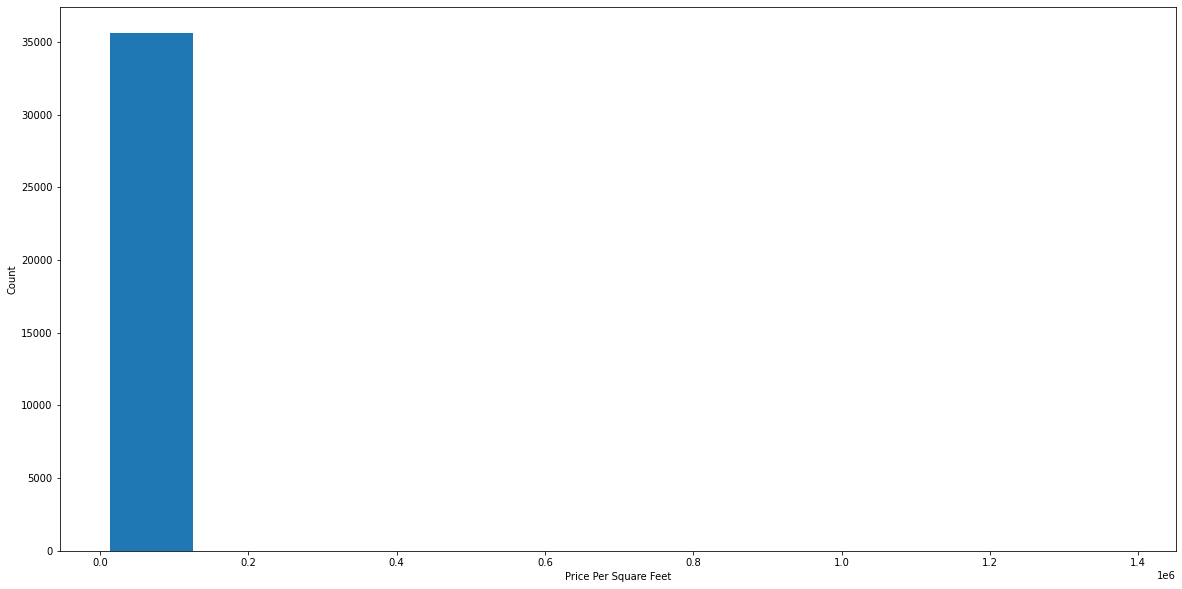

In [ ]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df3.price_per_sqft_SRB,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

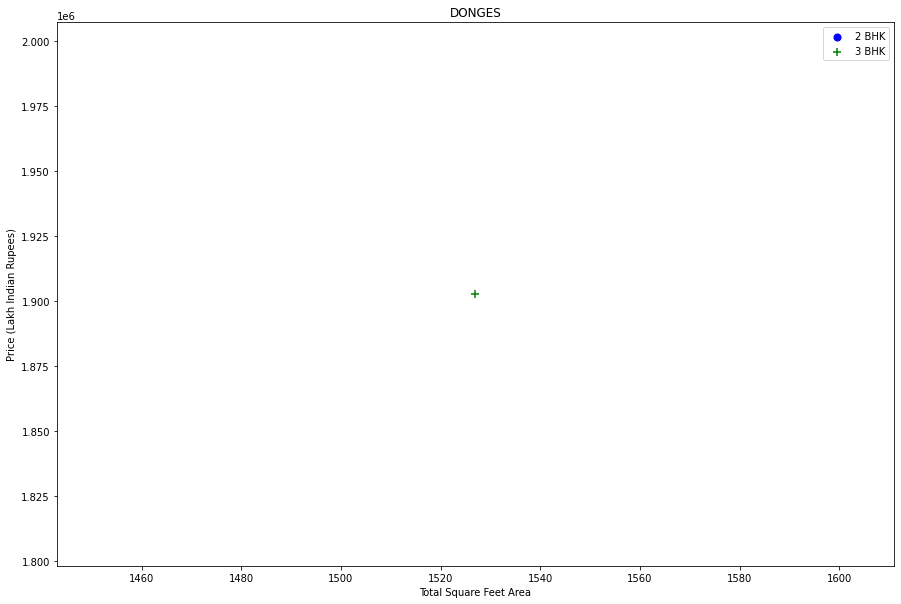

In [ ]:
def drw_scatter_graph(df,Commune):
    bhk59 = df[(df.Commune==Commune) & (df.No_piece_principal_Maison==77)]
    bhk61 = df[(df.Commune==Commune) & (df.No_piece_principal_Maison==81)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk59.Surface_reelle_bati,bhk59.valeur_fonciere,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk61.Surface_reelle_bati,bhk61.valeur_fonciere,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(Commune)
    plt.legend()
    
drw_scatter_graph(df3,"DONGES")

In [ ]:
df3

mutation_date    Commune  Code_postal  nombre_de_local  \
0                 16   ABBARETZ        44170               49   
1                  4   ABBARETZ        44170                6   
2                  1   ABBARETZ        44170                2   
3                  1   ABBARETZ        44170                3   
4                  1   ABBARETZ        44170                1   
...              ...        ...          ...              ...   
35617              3  ZUTKERQUE        62370                6   
35618              1  ZUTKERQUE        62370                1   
35619              1  ZUTKERQUE        62370                2   
35620              3  ZUTKERQUE        62370                6   
35621              7  ZUTKERQUE        62370               16   

      Code_departement  Code_commune Section Nature_mutation  v_f_achèvement  \
0                   44             1      AB           Vente               0   
1                   44             1      AC           Vente               0   
2                   44             1      AK           Vente               0   
3                   44             1      AM           Vente               0   
4                   44             1      BM           Vente               0   
...                ...           ...     ...             ...             ...   
35617               62           906      AI           Vente               0   
35618               62           906      AK           Vente               0   
35619               62           906      AN           Vente               0   
35620               62           906      AO           Vente               0   
35621               62           906       C           Vente               0   

       valeur_fonciere  No_disposition  No_de_lot_disposition  \
0          5767000.000               1                      1   
1           640000.000               1                      1   
2           280000.000               1                      1   
3           270678.000               1                      1   
4           255000.000               1                      1   
...                ...             ...                    ...   
35617       860000.000               1                      1   
35618       150000.000               1                      1   
35619       530000.000               1                      1   
35620       843500.000               1                      1   
35621      2746796.000               1                      1   

       Surface_reelle_bati  Nombre_de_locaux_mute  Nombre_d_appartements  \
0                 3716.000                      3                  1.000   
1                  500.000                      1                  0.000   
2                  174.000                      1                  0.000   
3                  210.000                      1                  0.000   
4                  172.000                      1                  0.000   
...                    ...                    ...                    ...   
35617              574.000                      1                  0.000   
35618              128.000                      1                  0.000   
35619              402.000                      1                  0.000   
35620              525.000                      1                  0.000   
35621             1669.000                      1                  0.000   

       Nombre_d_ependence  Nombre_d_maison  No_piece_principal_appartements  \
0                   1.000            1.000                                8   
1                   0.000            1.000                                0   
2                   0.000            1.000                                0   
3                   0.000            1.000                                0   
4                   0.000            1.000                                0   
...                   ...              ...                              ...   
35617             

In [ ]:
from collections import Counter# to look at the distribution in commune thus imputing missing values by group

In [ ]:
Counter(df3['Code_departement'].values).most_common()

[('44', 2131),
 ('59', 1436),
 ('56', 1426),
 ('35', 1229),
 ('33', 1186),
 ('85', 1068),
 ('22', 1033),
 ('62', 920),
 ('13', 909),
 ('49', 756),
 ('30', 689),
 ('50', 680),
 ('93', 674),
 ('45', 641),
 ('29', 624),
 ('77', 621),
 ('69', 617),
 ('24', 601),
 ('79', 589),
 ('17', 583),
 ('76', 582),
 ('86', 566),
 ('34', 531),
 ('94', 520),
 ('40', 518),
 ('91', 515),
 ('72', 492),
 ('78', 487),
 ('83', 476),
 ('84', 453),
 ('42', 442),
 ('47', 393),
 ('95', 391),
 ('16', 388),
 ('87', 385),
 ('60', 364),
 ('31', 363),
 ('28', 357),
 ('6', 349),
 ('41', 346),
 ('18', 336),
 ('88', 334),
 ('71', 314),
 ('37', 304),
 ('53', 302),
 ('3', 289),
 ('63', 286),
 ('89', 285),
 ('81', 268),
 ('92', 253),
 ('26', 251),
 ('19', 250),
 ('974', 250),
 ('64', 247),
 ('38', 240),
 ('1', 237),
 ('82', 220),
 ('11', 201),
 ('32', 200),
 ('43', 197),
 ('61', 188),
 ('58', 176),
 ('54', 175),
 ('14', 172),
 ('27', 170),
 ('80', 167),
 ('39', 161),
 ('2', 140),
 ('23', 139),
 ('70', 134),
 ('4', 106),
 ('

In [ ]:
dpt_44 = df3[(df3['Code_departement'] == '44')]
dpt_44

mutation_date   Commune  Code_postal  nombre_de_local Code_departement  \
0                 16  ABBARETZ        44170               49               44   
1                  4  ABBARETZ        44170                6               44   
2                  1  ABBARETZ        44170                2               44   
3                  1  ABBARETZ        44170                3               44   
4                  1  ABBARETZ        44170                1               44   
...              ...       ...          ...              ...              ...   
35078              2  VILLEPOT        44110               10               44   
35079              1  VILLEPOT        44110                2               44   
35080              1  VILLEPOT        44110                5               44   
35081              2  VILLEPOT        44110                5               44   
35082              4  VILLEPOT        44110               13               44   

       Code_commune Section Nature_mutation  v_f_achèvement  valeur_fonciere  \
0                 1      AB           Vente               0      5767000.000   
1                 1      AC           Vente               0       640000.000   
2                 1      AK           Vente               0       280000.000   
3                 1      AM           Vente               0       270678.000   
4                 1      BM           Vente               0       255000.000   
...             ...     ...             ...             ...              ...   
35078           218      ZM           Vente               0      1809000.000   
35079           218      ZO           Vente               0       310000.000   
35080           218      ZR           Vente               0       350000.000   
35081           218      ZS           Vente               0       335500.000   
35082           218      ZV           Vente               0       978838.000   

       No_disposition  No_de_lot_disposition  Surface_reelle_bati  \
0                   1                      1             3716.000   
1                   1                      1              500.000   
2                   1                      1              174.000   
3                   1                      1              210.000   
4                   1                      1              172.000   
...               ...                    ...                  ...   
35078               1                      1             1018.000   
35079               1                      1              410.000   
35080               1                      1              380.000   
35081               1                      1              340.000   
35082               1                      1              522.000   

       Nombre_de_locaux_mute  Nombre_d_appartements  Nombre_d_ependence  \
0                          3                  1.000               1.000   
1                          1                  0.000               0.000   
2                          1                  0.000               0.000   
3                          1                  0.000               0.000   
4                          1                  0.000               0.000   
...                      ...                    ...                 ...   
35078                      1                  0.000               0.000   
35079                      1                  0.000               0.000   
35080                      1                  0.000               0.000   
35081                      1                  0.000               0.000   
35082                      1                  0.000               0.000   

       Nombre_d_maison  No_piece_principal_appartements  \
0                1.000                                8   
1                1.000                                0   
2                1.000                                0   
3                1.000                                0   
4                1.000                          

Thus we select department 33 for which most transaction took place.Let us now consider only the department of Gironde. In the graph below we have the 30 municipalities for which we have the most data, in other words where there are the most real estate transactions. For the rest of the analysis, we'll use all the data.

In [ ]:
df4 = dpt_44.drop(['price_per_sqft_SRB','No_piece_principal_Maison', 'No_piece_principal_Dépendance', 'No_piece_principal_appartements', 'Nombre_d_ependence',
'No_de_lot_disposition', 'No_disposition', 'Section', 'Code_commune', 'Code_departement', 'Code_postal', 'mutation_date'],axis='columns')
df4.head(3)

Commune  nombre_de_local Nature_mutation  v_f_achèvement  valeur_fonciere  \
0  ABBARETZ               49           Vente               0      5767000.000   
1  ABBARETZ                6           Vente               0       640000.000   
2  ABBARETZ                2           Vente               0       280000.000   

   Surface_reelle_bati  Nombre_de_locaux_mute  Nombre_d_appartements  \
0             3716.000                      3                  1.000   
1              500.000                      1                  0.000   
2              174.000                      1                  0.000   

   Nombre_d_maison  
0            1.000  
1            1.000  
2            1.000

<AxesSubplot:>

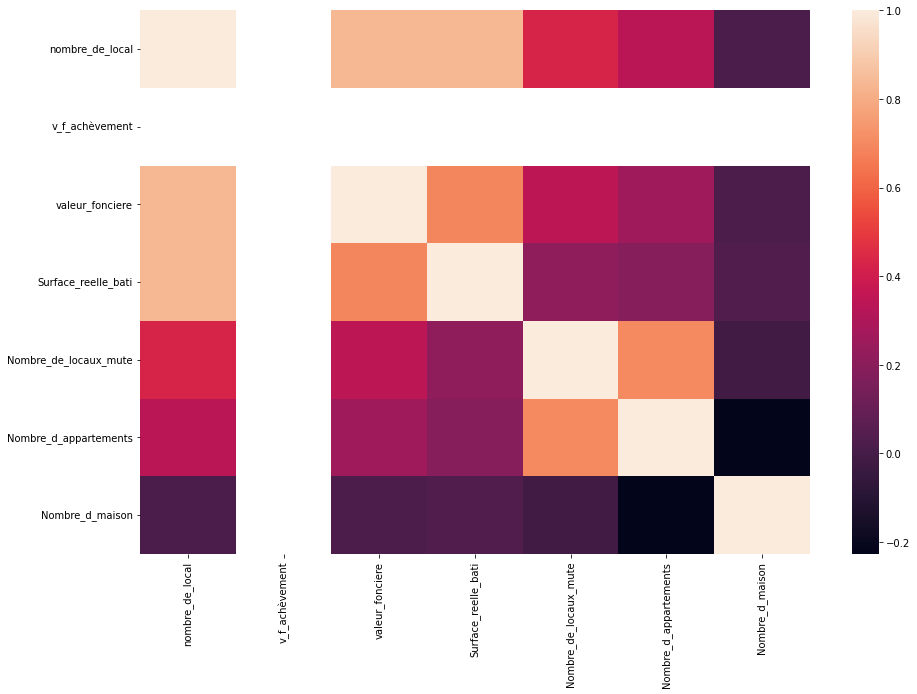

In [ ]:
#figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

corr=df4.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [ ]:
df4.to_csv('df44.csv', index=False)

Use One Hot Encoding For Location and nature mutation

In [ ]:
#label encoding
# converting type of columns to 'category'
df4['Nature_mutation'] = df4['Nature_mutation'].astype('category')
# Assigning numerical values and storing in another column
df4['Nature_mutation'] = df4['Nature_mutation'].cat.codes
df4

Commune  nombre_de_local  Nature_mutation  v_f_achèvement  \
0      ABBARETZ               49                2               0   
1      ABBARETZ                6                2               0   
2      ABBARETZ                2                2               0   
3      ABBARETZ                3                2               0   
4      ABBARETZ                1                2               0   
...         ...              ...              ...             ...   
35078  VILLEPOT               10                2               0   
35079  VILLEPOT                2                2               0   
35080  VILLEPOT                5                2               0   
35081  VILLEPOT                5                2               0   
35082  VILLEPOT               13                2               0   

       valeur_fonciere  Surface_reelle_bati  Nombre_de_locaux_mute  \
0          5767000.000             3716.000                      3   
1           640000.000              500.000                      1   
2           280000.000              174.000                      1   
3           270678.000              210.000                      1   
4           255000.000              172.000                      1   
...                ...                  ...                    ...   
35078      1809000.000             1018.000                      1   
35079       310000.000              410.000                      1   
35080       350000.000              380.000                      1   
35081       335500.000              340.000                      1   
35082       978838.000              522.000                      1   

       Nombre_d_appartements  Nombre_d_maison  
0                      1.000            1.000  
1                      0.000            1.000  
2                      0.000            1.000  
3                      0.000            1.000  
4                      0.000            1.000  
...                      ...              ...  
35078                  0.000            1.000  
35079                  0.000            1.000  
35080                  0.000            1.000  
35081                  0.000            1.000  
35082                  0.000            1.000  

[2131 rows x 9 columns]

In [ ]:
#One hot encoding - to convert categorical data to continuous
cat_vars = ['Commune']
df4[cat_vars] = df4[cat_vars].astype(str)
df5 = pd.get_dummies(df4, drop_first=True)
df5.head(5)

nombre_de_local  Nature_mutation  v_f_achèvement  valeur_fonciere  \
0               49                2               0      5767000.000   
1                6                2               0       640000.000   
2                2                2               0       280000.000   
3                3                2               0       270678.000   
4                1                2               0       255000.000   

   Surface_reelle_bati  Nombre_de_locaux_mute  Nombre_d_appartements  \
0             3716.000                      3                  1.000   
1              500.000                      1                  0.000   
2              174.000                      1                  0.000   
3              210.000                      1                  0.000   
4              172.000                      1                  0.000   

   Nombre_d_maison  Commune_AIGREFEUILLE SUR MAINE  Commune_ASSERAC  \
0            1.000                               0                0   
1            1.000                               0                0   
2            1.000                               0                0   
3            1.000                               0                0   
4            1.000                               0                0   

   Commune_AVESSAC  Commune_BASSE-GOULAINE  Commune_BATZ-SUR-MER  \
0                0                       0                     0   
1                0                       0                     0   
2                0                       0                     0   
3                0                       0                     0   
4                0                       0                     0   

   Commune_BESNE  Commune_BIGNON (LE)  Commune_BOUAYE  Commune_BOUGUENAIS  \
0              0                    0               0                   0   
1              0                    0               0                   0   
2              0                    0               0                   0   
3              0                    0               0                   0   
4              0                    0               0                   0   

   Commune_BOUSSAY  Commune_BOUVRON  Commune_BRAINS  Commune_CELLIER (LE)  \
0                0                0               0                     0   
1                0                0               0                     0   
2                0                0               0                     0   
3                0                0               0                     0   
4                0                0               0                     0   

   Commune_CHAPELLE-HEULIN (LA)  Commune_CHAPELLE-SUR-ERDRE (LA)  \
0                             0                                0   
1                             0                                0   
2                             0                                0   
3                             0                                0   
4                             0                                0   

   Commune_CHATEAU-THEBAUD  Commune_CHATEAUBRIANT  Commune_CHAUMES-EN-RETZ  \
0                        0                      0                        0   
1                        0                      0                        0   
2                        0                      0                        0   
3                        0                      0                        0   
4                        0                      0                        0   

   Commune_CHAUVE  Commune_CHEVROLIERE (LA)  Commune_CORCOUE-SUR-LOGNE  \
0               0                         0                          0   
1               0                         0                          0   
2               0                         0                          0   
3               0                         0                          0   
4               0                         0                          0   

   Commune_CORDEMAIS  Commune_CORSEPT  Commune_COUFF

In [ ]:
df5['Nombre_d_appartements'] = df5['Nombre_d_appartements'].apply(np.int64)
df5['Nombre_d_maison'] = df5['Nombre_d_maison'].apply(np.int64)

In [ ]:
df5.to_csv('df5.csv', index=False)

In [ ]:
df5.shape

(2131, 129)

In [ ]:
# Standardizing
from sklearn.preprocessing import StandardScaler
con_vars = ['nombre_de_local', 'valeur_fonciere',
           'Nombre_de_locaux_mute', 'Surface_reelle_bati', 'Nombre_d_appartements',
           'Nombre_d_maison']
scaler = StandardScaler()
df5[con_vars]=scaler.fit_transform(df5[con_vars])
df5.head(5)

nombre_de_local  Nature_mutation  v_f_achèvement  valeur_fonciere  \
0            2.521                2               0            0.702   
1           -0.423                2               0           -0.466   
2           -0.696                2               0           -0.548   
3           -0.628                2               0           -0.550   
4           -0.765                2               0           -0.554   

   Surface_reelle_bati  Nombre_de_locaux_mute  Nombre_d_appartements  \
0                1.983                  3.926                  3.956   
1               -0.494                 -0.406                 -0.253   
2               -0.746                 -0.406                 -0.253   
3               -0.718                 -0.406                 -0.253   
4               -0.747                 -0.406                 -0.253   

   Nombre_d_maison  Commune_AIGREFEUILLE SUR MAINE  Commune_ASSERAC  \
0            0.057                               0                0   
1            0.057                               0                0   
2            0.057                               0                0   
3            0.057                               0                0   
4            0.057                               0                0   

   Commune_AVESSAC  Commune_BASSE-GOULAINE  Commune_BATZ-SUR-MER  \
0                0                       0                     0   
1                0                       0                     0   
2                0                       0                     0   
3                0                       0                     0   
4                0                       0                     0   

   Commune_BESNE  Commune_BIGNON (LE)  Commune_BOUAYE  Commune_BOUGUENAIS  \
0              0                    0               0                   0   
1              0                    0               0                   0   
2              0                    0               0                   0   
3              0                    0               0                   0   
4              0                    0               0                   0   

   Commune_BOUSSAY  Commune_BOUVRON  Commune_BRAINS  Commune_CELLIER (LE)  \
0                0                0               0                     0   
1                0                0               0                     0   
2                0                0               0                     0   
3                0                0               0                     0   
4                0                0               0                     0   

   Commune_CHAPELLE-HEULIN (LA)  Commune_CHAPELLE-SUR-ERDRE (LA)  \
0                             0                                0   
1                             0                                0   
2                             0                                0   
3                             0                                0   
4                             0                                0   

   Commune_CHATEAU-THEBAUD  Commune_CHATEAUBRIANT  Commune_CHAUMES-EN-RETZ  \
0                        0                      0                        0   
1                        0                      0                        0   
2                        0                      0                        0   
3                        0                      0                        0   
4                        0                      0                        0   

   Commune_CHAUVE  Commune_CHEVROLIERE (LA)  Commune_CORCOUE-SUR-LOGNE  \
0               0                         0                          0   
1               0                         0                          0   
2               0                         0                          0   
3               0                         0                          0   
4               0                         0                          0   

   Commune_CORDEMAIS  Commune_CORSEPT  Commune_COUFF

PCA

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [ ]:
# PCA
from sklearn.decomposition import PCA
# Loop Function to identify number of principal components that explain at least 85% of the variance
for comp in range(3, df5.shape[1]):
    pca = PCA(n_components= comp, random_state=42)
    pca.fit(df5)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() > 0.85:
        break
        
Final_PCA = PCA(n_components= final_comp,random_state=42)
Final_PCA.fit(df5)
cluster_df=Final_PCA.transform(df5)
num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(final_comp,comp_check.sum()))

Using 6 components, we can explain 0.8577592189598321% of the variability in the original data.


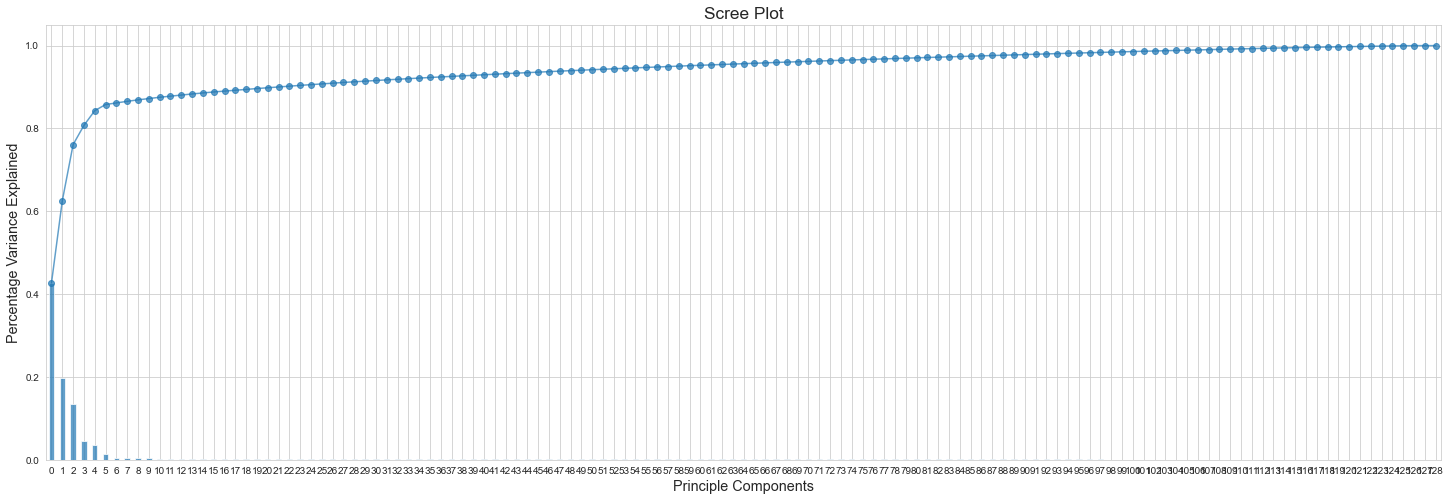

In [ ]:
pca = PCA()
pca.fit(df5)
sns.color_palette("YlOrBr", as_cmap=True)
plt.figure(figsize=(25,8))
exp_var = pd.Series(pca.explained_variance_ratio_)
exp_var.plot(kind="bar", alpha=0.7) # plot bar chart

# Calculate the amount of variance explained added by each additional component
total = 0
var_ls = []
for x in exp_var:
    total += x
    var_ls.append(total)

pd.Series(var_ls).plot(marker="o", alpha=0.7) #plot line chart of increasing variances
plt.xlabel("Principle Components", fontsize="x-large")
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("Scree Plot", fontsize="xx-large")
plt.show();

Clustering

Build a Model Now...

In [ ]:

X = df5.drop(['valeur_fonciere'],axis='columns', inplace=False)
y = df5['valeur_fonciere']

array([[<AxesSubplot:title={'center':'1. Before'}>,
        <AxesSubplot:title={'center':'2. After'}>]], dtype=object)

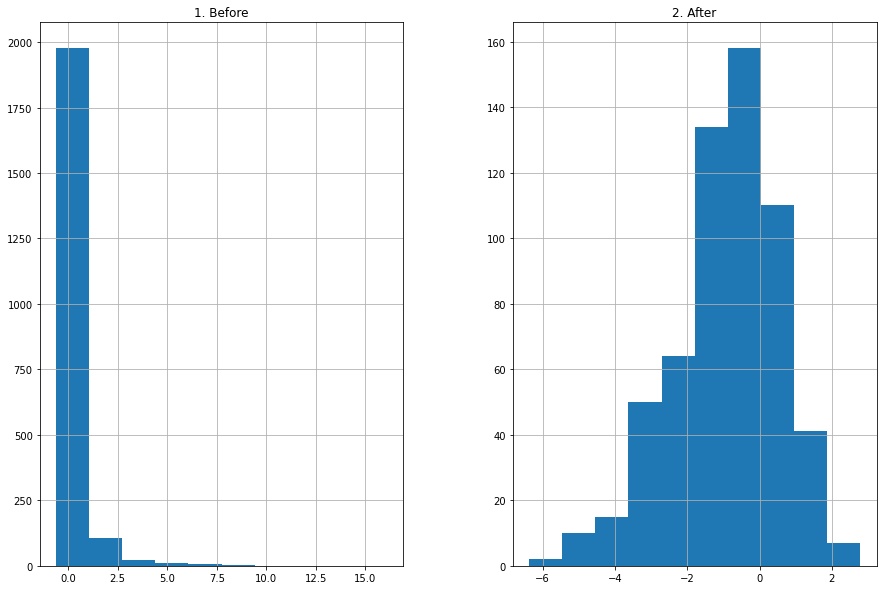

In [ ]:
valeur_fonciere =pd.DataFrame({"1. Before":y, "2. After": np.log(y)})
valeur_fonciere.hist()

In [ ]:
y

0        0.702
1       -0.466
2       -0.548
3       -0.550
4       -0.554
         ...  
35078   -0.200
35079   -0.541
35080   -0.532
35081   -0.536
35082   -0.389
Name: valeur_fonciere, Length: 2131, dtype: float64

In [ ]:
#scaled price
y = (y -np.mean(y))/np.sqrt(np.var(y))

In [ ]:
len(y)

2131

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.8052886023692452

Use K Fold cross validation to measure accuracy of our LinearRegression model

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.8052886 , 0.78599578, 0.71773542, 0.66627714, 0.83114725])


We can see that in 5 iterations we get a score below 20% all the time. This is pretty bad but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV and randomsearch for this purpose

Now finally I will try to predict price using three basic ML methods: linear regression, decision trees and random forest. I will first prepare the inputs (feature scaling and one-hot encoding), then I will apply the models to the train set. RMSE will be the major metrics to evaluate the performances of the models. Cross-validation will also be used to select the best performing model, which I will then fine tune.

and then test them on train data, in terms of MSE:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split # data split

from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge # Ridge algorithm
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

sns.set_style('whitegrid') # plot style
plt.rcParams['figure.figsize'] = (20, 10) # plot size

In [ ]:
#fit decision tree
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
#fit random forest
forest = RandomForestRegressor(n_jobs=-1)
forest.fit(X_train, y_train)
#fit ridge regression
ridge = Ridge()
ridge.fit(X_train, y_train)
#fit lasso regression
lasso = Lasso()
lasso.fit(X_train, y_train)
#fit Elasticnet regression
elas = ElasticNet()
elas.fit(X_train, y_train)
#fit regression
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [ ]:
models= [('lin_reg', lin_reg), ('random forest', forest), ('decision tree', tree),('ridge', ridge), ('lasso', lasso), ('elas', elas)]
from sklearn.metrics import mean_squared_error
for i, model in models:    
    predictions = model.predict(X_train)
    MSE = mean_squared_error(y_train, predictions)
    RMSE = np.sqrt(MSE)
    msg = "%s = %.2f" % (i, round(RMSE, 2))
    print('RMSE of', msg)

RMSE of lin_reg = 0.51
RMSE of random forest = 0.24
RMSE of decision tree = 0.01
RMSE of ridge = 0.51
RMSE of lasso = 1.02
RMSE of elas = 0.84


In [ ]:
for i, model in models:
    # Make predictions on train data
    predictions = model.predict(X_train)
    # Performance metrics
    errors = abs(predictions - y_train)
    # Calculate mean absolute percentage error (MAPE)
    mape = np.mean(100 * (errors / y_train))
    # Calculate and display accuracy
    accuracy = 100 - mape    
    #print result
    msg = "%s= %.2f"% (i, round(accuracy, 2))
    print('Accuracy of', msg,'%')

Accuracy of lin_reg= 153.56 %
Accuracy of random forest= 100.80 %
Accuracy of decision tree= 100.01 %
Accuracy of ridge= 154.38 %
Accuracy of lasso= 143.79 %
Accuracy of elas= 153.58 %


These results are interesting: it seems that decision tree is by far the best model, as its error is the lowest. However, at this point we are only evaluating our models on the train set, so the risk of overfitting for decision trees is quite high. To understand better the performances of the models we can use an alternative strategy: cross-validation.

Model comparison. I will cross-validate the three models and compare them

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
models= [('lin_reg', lin_reg), ('forest', forest), ('dt', tree),('ridge', ridge), ('lasso', lasso), ('elas', elas)]
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

#for each model I want to test three different scoring metrics. Therefore, results[0] will be lin_reg x MSE, 
# results[1] lin_reg x MSE and so on until results [8], where we stored dt x r2

results= []
metric= []
for name, model in models:
    for i in scoring:
        scores = cross_validate(model, X_train, y_train, scoring=i, cv=10, return_train_score=True)
        results.append(scores)

In [ ]:
#this is an example of the stored results
results[8]

{'fit_time': array([0.02174592, 0.02097821, 0.02097511, 0.02794003, 0.02097011,
        0.02067804, 0.02006292, 0.02083111, 0.019629  , 0.02031994]),
 'score_time': array([0.00289202, 0.00447798, 0.00876498, 0.00431299, 0.00306296,
        0.003196  , 0.00284219, 0.00278378, 0.00440097, 0.00290585]),
 'test_score': array([ 0.62395644, -2.14024215,  0.7068324 , -0.05868001,  0.58717328,
         0.69036855,  0.65864063,  0.72133553,  0.18438365,  0.56847433]),
 'train_score': array([0.99996305, 0.99997571, 0.99996654, 0.999965  , 0.9999742 ,
        0.99999205, 0.99999253, 0.999967  , 0.99996933, 0.9999659 ])}

Now I want to compute for each combination the mean and std, so that to put into a dataframe all the metrics and easily compare them

In [ ]:
#THIS IS FOR Linear regression
#if you change signa and square the Mean Square Error you get the RMSE, which is the most common metric to accuracy
LR_RMSE_mean = np.sqrt(-results[0]['test_score'].mean())
LR_RMSE_std= results[0]['test_score'].std()
# note that also here I changed the sign, as the result is originally a negative number for ease of computation
LR_MAE_mean = -results[1]['test_score'].mean()
LR_MAE_std= results[1]['test_score'].std()
LR_r2_mean = results[2]['test_score'].mean()
LR_r2_std = results[2]['test_score'].std()

#THIS IS FOR RF
RF_RMSE_mean = np.sqrt(-results[3]['test_score'].mean())
RF_RMSE_std= results[3]['test_score'].std()
RF_MAE_mean = -results[4]['test_score'].mean()
RF_MAE_std= results[4]['test_score'].std()
RF_r2_mean = results[5]['test_score'].mean()
RF_r2_std = results[5]['test_score'].std()

#THIS IS FOR DT
DT_RMSE_mean = np.sqrt(-results[6]['test_score'].mean())
DT_RMSE_std= results[6]['test_score'].std()
DT_MAE_mean = -results[7]['test_score'].mean()
DT_MAE_std= results[7]['test_score'].std()
DT_r2_mean = results[8]['test_score'].mean()
DT_r2_std = results[8]['test_score'].std()

NameError: name 'np' is not defined

In [ ]:
modelDF = pd.DataFrame({
    'Model'       : ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet', 'Random Forest', 'Decision Trees'],
    'RMSE_mean'    : [LR_RMSE_mean, RF_RMSE_mean, DT_RMSE_mean],
    'RMSE_std'    : [LR_RMSE_std, RF_RMSE_std, DT_RMSE_std],
    'MAE_mean'   : [LR_MAE_mean, RF_MAE_mean, DT_MAE_mean],
    'MAE_std'   : [LR_MAE_std, RF_MAE_std, DT_MAE_std],
    'r2_mean'      : [LR_r2_mean, RF_r2_mean, DT_r2_mean],
    'r2_std'      : [LR_r2_std, RF_r2_std, DT_r2_std],
    }, columns = ['Model', 'RMSE_mean', 'RMSE_std', 'MAE_mean', 'MAE_std', 'r2_mean', 'r2_std'])

modelDF.sort_values(by='r2_mean', ascending=False)

ValueError: All arrays must be of the same length

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


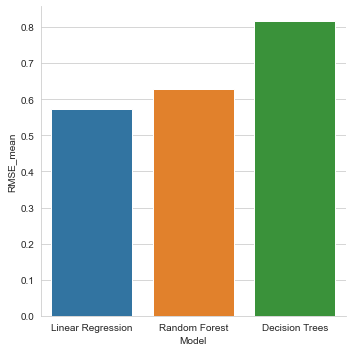

In [ ]:
sns.factorplot(x= 'Model', y= 'RMSE_mean', data= modelDF, kind='bar', legend='True')

Fine-tuning all models

In [ ]:

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'ElasticNet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [1,2],
                'normalize': [True, False]
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'RandomForestRegressor': {
            'model': RandomForestRegressor(),
            'params': {
                'criterion' : ['squared_error']
            }
        },
        'GradientBoostingRegressor': {
            'model': GradientBoostingRegressor(),
            'params': {
                'criterion' : ['friedman_mse'] 
            }
        },
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

model  best_score  \
0          linear_regression       0.788   
1                      lasso      -0.005   
2                 ElasticNet       0.379   
3                      ridge       0.793   
4              decision_tree       0.514   
5      RandomForestRegressor       0.747   
6  GradientBoostingRegressor       0.735   

                                         best_params  
0                                {'normalize': True}  
1                {'alpha': 1, 'selection': 'random'}  
2                {'alpha': 1, 'selection': 'cyclic'}  
3                   {'alpha': 2, 'normalize': False}  
4  {'criterion': 'friedman_mse', 'splitter': 'ran...  
5                     {'criterion': 'squared_error'}  
6                      {'criterion': 'friedman_mse'}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
def find_best_model_using_randomsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'ElasticNet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [1,2],
                'normalize': [True, False]
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'RandomForestRegressor': {
            'model': RandomForestRegressor(),
            'params': {
                'criterion' : ['squared_error']
            }
        },
        'GradientBoostingRegressor': {
            'model': GradientBoostingRegressor(),
            'params': {
                'criterion' : ['friedman_mse'] 
            }
        },
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        rs =  RandomizedSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        rs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': rs.best_score_,
            'best_params': rs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_randomsearchcv(X,y)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Library/Frameworks/Python.framework

model  best_score  \
0          linear_regression       0.788   
1                      lasso      -0.005   
2                 ElasticNet       0.379   
3                      ridge       0.793   
4              decision_tree       0.574   
5      RandomForestRegressor       0.765   
6  GradientBoostingRegressor       0.734   

                                  best_params  
0                         {'normalize': True}  
1         {'selection': 'random', 'alpha': 1}  
2         {'selection': 'cyclic', 'alpha': 1}  
3            {'normalize': False, 'alpha': 2}  
4  {'splitter': 'random', 'criterion': 'mse'}  
5              {'criterion': 'squared_error'}  
6               {'criterion': 'friedman_mse'}

Send test model to pickle

In [ ]:
with open('44_realestate_prices_model.pickle','wb') as f:
    pickle.dump(lr,f)

Send location and column data to a file that will be expedient later on for our prediction software

In [ ]:
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))